<a href="https://colab.research.google.com/github/OUCHAOUA/Unsupervased-Cluster/blob/master/Unsupervased_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Chargez votre jeu de données. 

2. Utilisez le clustering hiérarchique pour identifier les regroupements inhérents à vos données.

3. Tracez les grappes. 

4. Tracez le dendrogramme. Utilisez le clustering k-means. 

5. Essayez différentes valeurs de k et sélectionnez la meilleure. 

6. Tracez les grappes. 

7. Comparez les deux résultats. 

Bonus: recherchez une autre métrique de validation

In [3]:
import pandas as pd
from google.colab import files
data_to_load = files.upload()
 
import io
data = pd.read_csv(io.BytesIO(data_to_load['CC GENERAL.csv']))
data

Saving CC GENERAL.csv to CC GENERAL.csv


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [4]:
data = data.drop("CUST_ID", axis=1)

In [5]:
data.shape

(8950, 17)

In [6]:
data.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS       313
CREDIT_LIMIT             1
TENURE                   0
PURCHASES_FREQUENCY      0
BALANCE_FREQUENCY        0
dtype: int64

In [7]:
# NAN
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean( )
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

In [8]:
for col in data.columns:
    print('{:40} : {:10} : {:}'.format(col, data[col].nunique(), data[col].dtype))

BALANCE                                  :       8871 : float64
BALANCE_FREQUENCY                        :         43 : float64
PURCHASES                                :       6203 : float64
ONEOFF_PURCHASES                         :       4014 : float64
INSTALLMENTS_PURCHASES                   :       4452 : float64
CASH_ADVANCE                             :       4323 : float64
PURCHASES_FREQUENCY                      :         47 : float64
ONEOFF_PURCHASES_FREQUENCY               :         47 : float64
PURCHASES_INSTALLMENTS_FREQUENCY         :         47 : float64
CASH_ADVANCE_FREQUENCY                   :         54 : float64
CASH_ADVANCE_TRX                         :         65 : int64
PURCHASES_TRX                            :        173 : int64
CREDIT_LIMIT                             :        206 : float64
PAYMENTS                                 :       8711 : float64
MINIMUM_PAYMENTS                         :       8637 : float64
PRC_FULL_PAYMENT                         :  

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
X = np.asarray(data)
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

In [10]:
from sklearn.cluster import AgglomerativeClustering 

model = AgglomerativeClustering(n_clusters = 6, affinity = "cosine", linkage = "average")
       
clust_labels = model.fit_predict(X)

In [11]:
import numpy as np
agglomerative = pd.DataFrame(clust_labels)
agglomerative[0].value_counts()

0    3268
2    1621
5    1583
1    1538
3     845
4      95
Name: 0, dtype: int64

In [12]:
clusters=pd.concat([data, pd.DataFrame({'groupe':clust_labels})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,groupe
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,2
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,2
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [13]:
import matplotlib.pyplot as plt

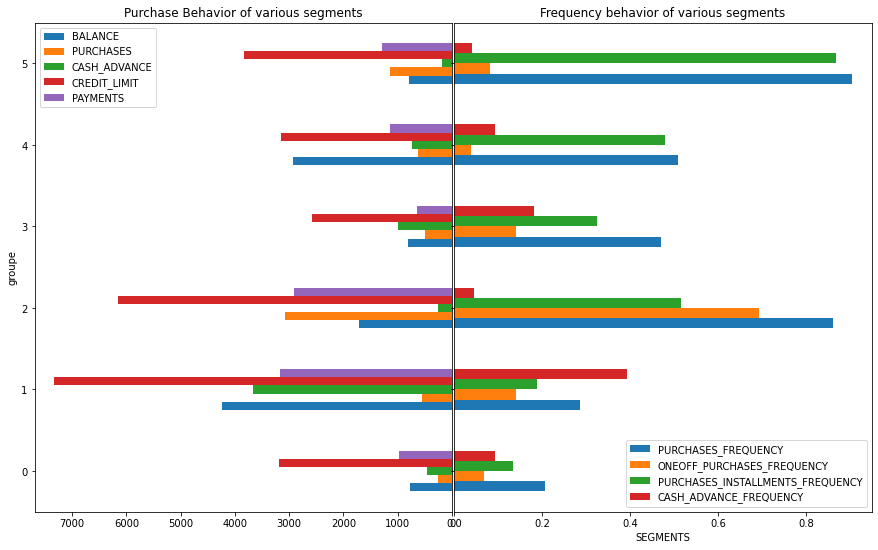

In [14]:
figure, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 9),gridspec_kw={'hspace': 0, 'wspace': .005}, sharey=True)
ax = clusters[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'groupe']].groupby('groupe').mean().plot.barh(ax = axes[0])
ax = ax.invert_xaxis()
axes[0].set_title('Purchase Behavior of various segments')
ax = clusters[['PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'groupe']].groupby('groupe').mean().plot.barh(ax = axes[1])
axes[1].set_title('Frequency behavior of various segments')
plt.xlabel('SEGMENTS');

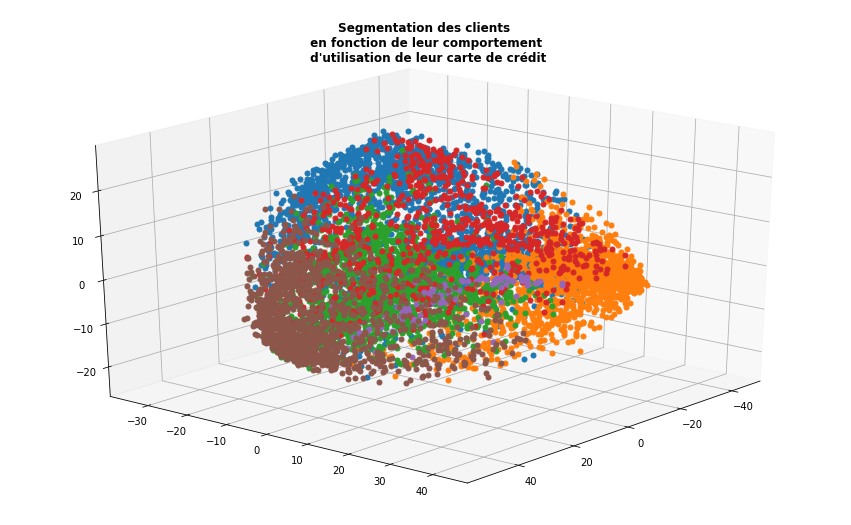

In [15]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import PCA
dist = cosine_similarity(X)

pca = PCA(3)
pca.fit(dist)
X_PCA = pca.transform(dist)

df = pd.DataFrame({'x': X_PCA[:, 0], 'y':X_PCA[:, 1], 'z':X_PCA[:, 2],'label':clust_labels}) 
groups = df.groupby('label')

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

for client_groupe, group in groups:
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=5)
    ax.set_aspect('auto')


ax.view_init(25, 40)
ax.set_title('\nSegmentation des clients \n en fonction de leur comportement \n d\'utilisation de leur carte de crédit', fontweight="bold")
plt.show()

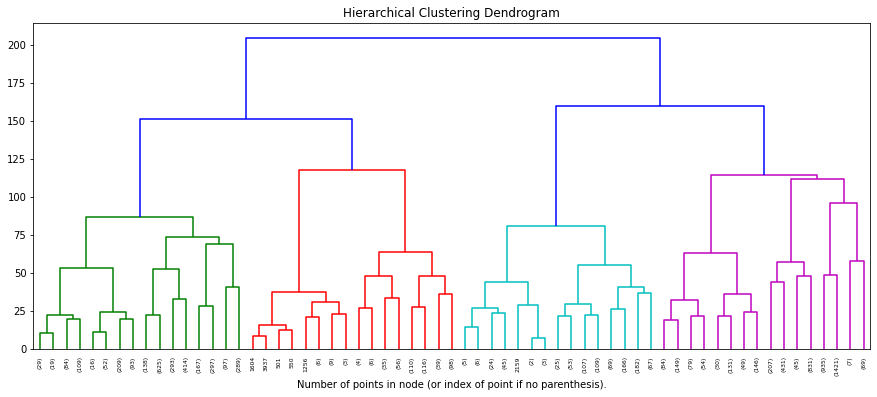

In [16]:
import scipy.cluster.hierarchy as shc

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    shc.dendrogram(linkage_matrix, **kwargs)


#Use AgglomerativeClustering Methode
model_deng = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model_deng.fit(X)


plt.figure(figsize=(15,6))  
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model_deng,truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [17]:
from sklearn.cluster import KMeans 

k_range = range(1,30)
cost=[]
for k in k_range:
    kmean= KMeans(k)
    kmean.fit(X)
    cost.append(kmean.inertia_) 

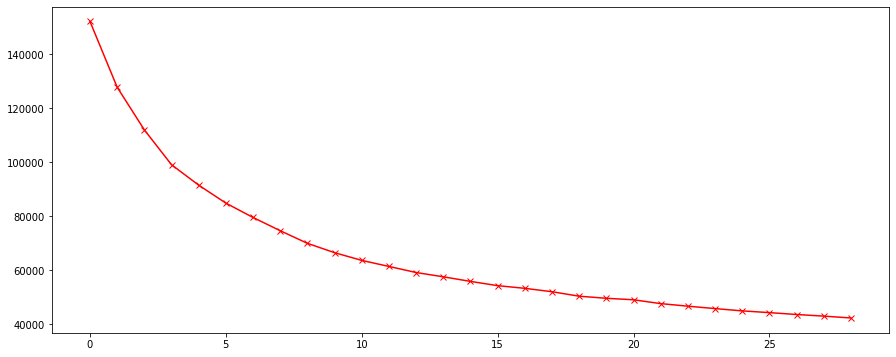

In [18]:
plt.figure(figsize=(15,6))    
plt.plot(cost, 'rx-')

In [19]:
kmean = KMeans(6)
kmean.fit(X)
cluster=kmean.labels_ + 1

In [20]:
clusters=pd.concat([data, pd.DataFrame({'groupe':cluster})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,groupe
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,6
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,5
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,6
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,6


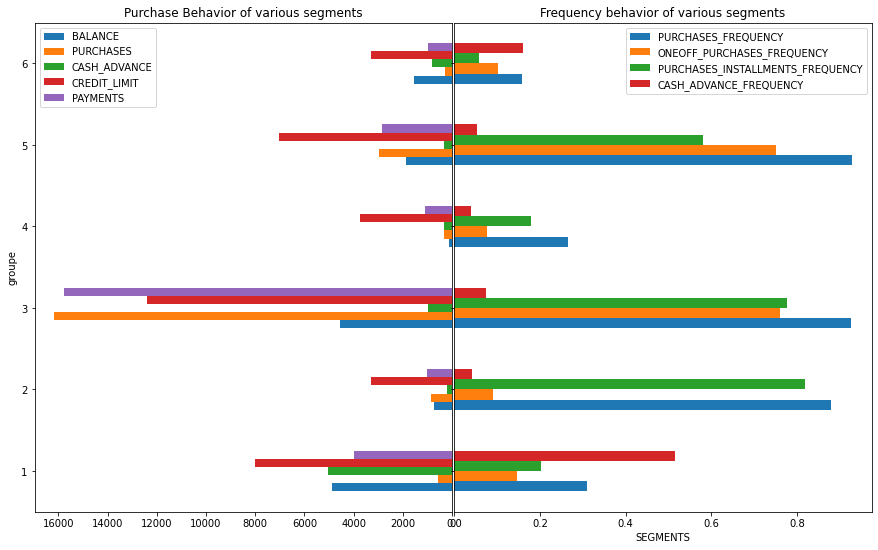

In [21]:
figure, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 9),gridspec_kw={'hspace': 0, 'wspace': .005}, sharey=True)
ax = clusters[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'groupe']].groupby('groupe').mean().plot.barh(ax = axes[0])
ax = ax.invert_xaxis()
axes[0].set_title('Purchase Behavior of various segments')
ax = clusters[['PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'groupe']].groupby('groupe').mean().plot.barh(ax = axes[1])
axes[1].set_title('Frequency behavior of various segments')
plt.xlabel('SEGMENTS');

In [35]:
groupe_client = {1: ('Groupe 01', 'red'),
                 2: ('Groupe 02', 'blue'),
                 3: ('Groupe 03', 'green'), 
                 4: ('Groupe 04' , 'yellow'), 
                 5: ('Groupe 05', 'orange'),  
                 6: ('Groupe 06', 'purple')}


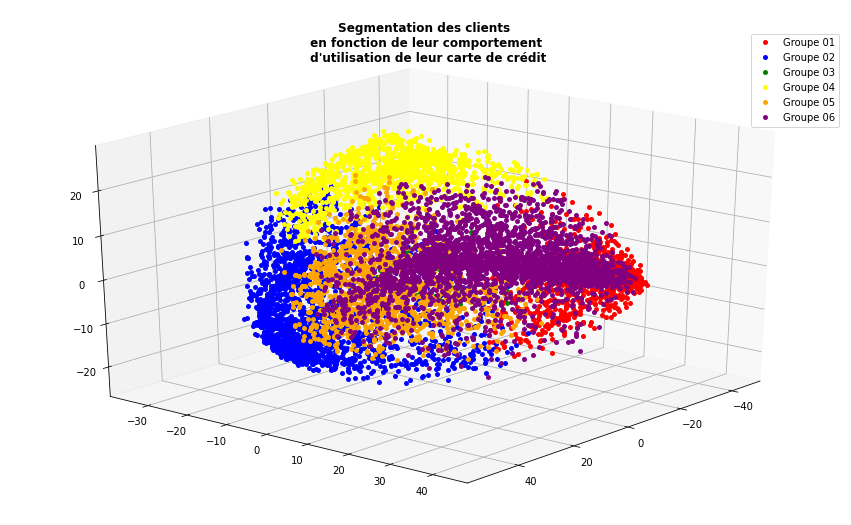

In [36]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import PCA
dist = cosine_similarity(X)

pca = PCA(3)
pca.fit(dist)
X_PCA = pca.transform(dist)

df = pd.DataFrame({'x': X_PCA[:, 0], 'y':X_PCA[:, 1], 'z':X_PCA[:, 2],'label':cluster}) 
groups = df.groupby('label')

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

for client_groupe, group in groups:
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=5,
            color=groupe_client[client_groupe][1],label=groupe_client[client_groupe][0], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')


ax.view_init(25, 40)
ax.legend()
ax.set_title('\nSegmentation des clients \n en fonction de leur comportement \n d\'utilisation de leur carte de crédit', fontweight="bold")
plt.show()

In [37]:
from sklearn.metrics.cluster import calinski_harabasz_score,silhouette_score
from sklearn.metrics import davies_bouldin_score

y_agg = model.fit_predict(X)
print ('AgglomerativeClustering ')
print ('calinski_harabasz_score  ', calinski_harabasz_score(data, y_agg))
print ('silhouette_score ', silhouette_score(data, y_agg, metric='euclidean'))

y_km = kmean.labels_
print ('KMeans')
print ('calinski_harabasz_score ', calinski_harabasz_score(data, y_km))
print ('silhouette_score ', silhouette_score(data, y_km, metric='euclidean'))

AgglomerativeClustering 
calinski_harabasz_score   645.9027865248656
silhouette_score  -0.06172820643122943
KMeans
calinski_harabasz_score  975.6678727426354
silhouette_score  0.004789034509020264


Dans cette analyse l'utilisation du **KMeans** donne un résultat significatif par rapport a **AgglomerativeClustering**  qui atteint même un  résultat négative